In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ircamt as ir
import twodpg

## Prep

Get a list of times from all files in the `data/csv_json` folder

In [2]:
tl, files = ir.make_timeline('../data/csv_json', ret_paths=True)
tl, files

(array([ 0.   , 12.372, 82.72 ]),
 [PosixPath('../data/csv_json/IR_5195.json'),
  PosixPath('../data/csv_json/IR_5197.json'),
  PosixPath('../data/csv_json/IR_5204.json')])

Files are the metadata `.json` files. They can be converted manually, or at once:

In [3]:
files = ir.get_csvs(files)
files

[PosixPath('../data/csv_json/IR_5195.csv'),
 PosixPath('../data/csv_json/IR_5197.csv'),
 PosixPath('../data/csv_json/IR_5204.csv')]

## Plot One Image and Define Regions of Interest

In [4]:
data = np.loadtxt('../data/csv_json/IR_5195.csv', delimiter=',')

In [5]:
rect1 = plt.Polygon(
    xy=[[300, 164], [300, 220], [360, 220], [360, 164]],
    edgecolor='white', facecolor='none', linewidth=1
)
rect2 = plt.Polygon(
    xy=[[250, 270], [250, 350], [320, 350], [320, 270]],
    edgecolor=plt.cm.Reds(.35), facecolor='none', linewidth=1
)

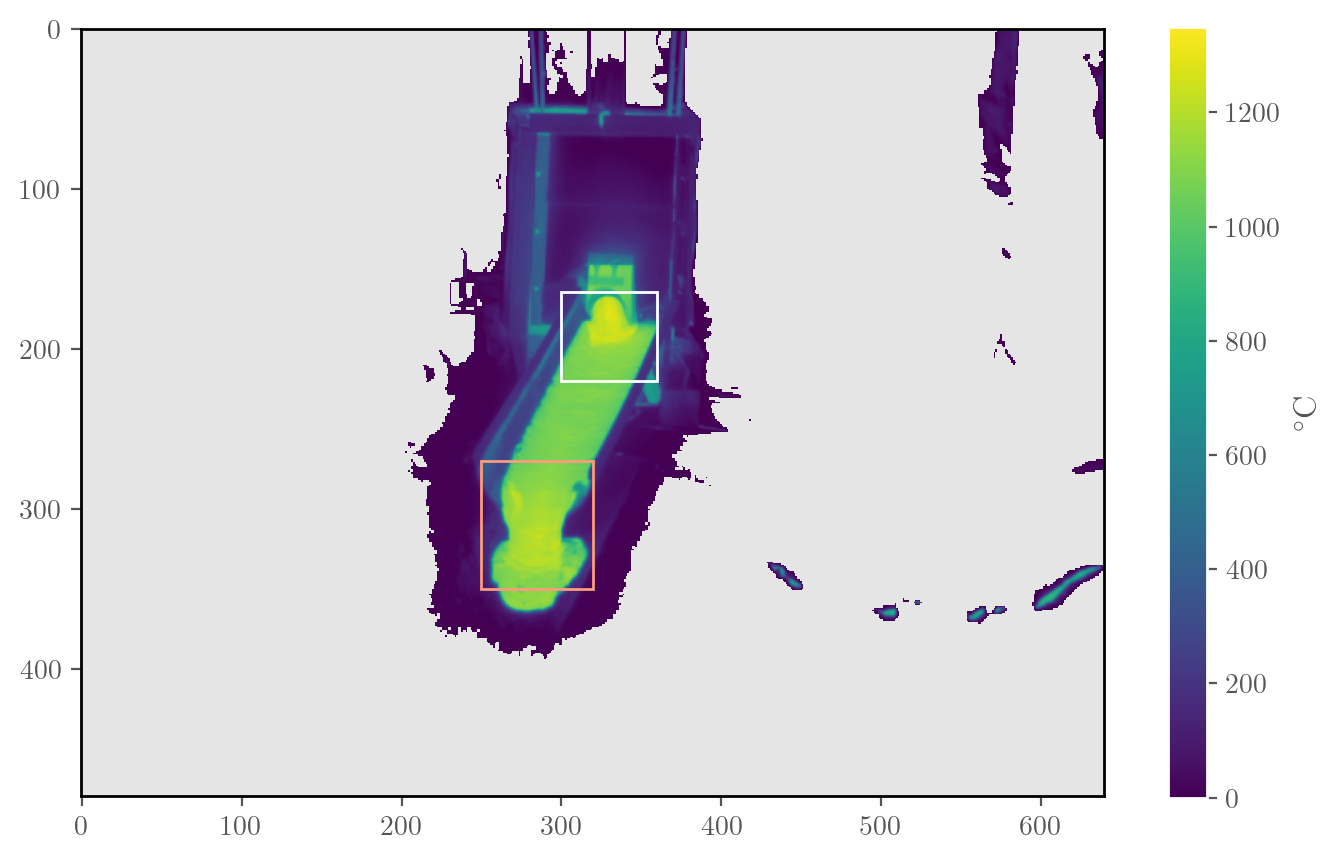

In [6]:
fig, ax = plt.subplots()

norm = plt.matplotlib.colors.Normalize(0, 1350)
plot = ax.imshow(data)
plot.set_norm(norm)
ax.grid(False)
fig.colorbar(plot, ax=ax, orientation='vertical', shrink=.82,
             label=r'$\mathrm{^\circ C}$')
ax.add_artist(rect1)
ax.add_artist(rect2)
for sp in ax.spines.values():
    sp.set_color('k')
fig.tight_layout()

## Analyze Data in ROIs

### Example: Get Max Temperature

... for all files in `data/`

In this example there are only two files, but in a real case a couple 100 files are realistic, which are typically arranged un a timeline.

`ircamt` has a `get()` function, which applies an arbitrary analysis function to a set of files, and a potential subset passed as image coordinates. `twodpg.image_index()` creates a list of all coordinate in an image, and `twodpg.points_in_polygon()` tells whether a given set of coordinates lies within a closed polygon.

An analysis function should not raise an error if invalid data is passed, but return `NaN`, so that the whole set can be processed.

In [7]:
def max_temp(tmps):
    idx = ~np.isnan(tmps)
    if np.any(idx):
        mx = np.max(tmps[idx])
    else:
        mx = np.nan
    return mx

List of all coordinates of this record set. It follows the image convention, so Column 0 are rows (vertical- or y coordinates), column 1 are columns (horizontal- or x-coordinates).

In [8]:
iidx = twodpg.image_index(*data.shape)
iidx[:5]

array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0]])

`points_in_polygon` returns 0 for points outside a polygon, 1 if inside, and 2 if on the boundary. Here points in and on the boundary are added to the selection.
Matplotlib's `Polygon.xy` property needs to be reversed to have y-coordinates at column 0, which is the reason for those `[:, ::-1]` brackets.

In [9]:
sel1 = iidx[twodpg.points_in_polygon(iidx, rect1.xy[:, ::-1]) > 0]
sel2 = iidx[twodpg.points_in_polygon(iidx, rect2.xy[:, ::-1]) > 0]

In [10]:
sel1

array([[164, 300],
       [165, 300],
       [166, 300],
       ...,
       [218, 360],
       [219, 360],
       [220, 360]])

In [11]:
max1 = ir.get(what=max_temp, files=files, sel=sel1, whatargs=(), nrvals=1)
max2 = ir.get(what=max_temp, files=files, sel=sel2)

In [12]:
max1, max2

(array([1293.43, 1181.19, 1032.96]), array([1249.18, 1179.74, 1022.16]))

The same result can be obtained in one call to `ir.get()` by passing the two selections in a list or tuple

In [13]:
max1, max2 = ir.get(max_temp, files, sel=(sel1, sel2), whatargs=(), nrvals=1)

In [14]:
max1, max2

(array([1293.43, 1181.19, 1032.96]), array([1249.18, 1179.74, 1022.16]))

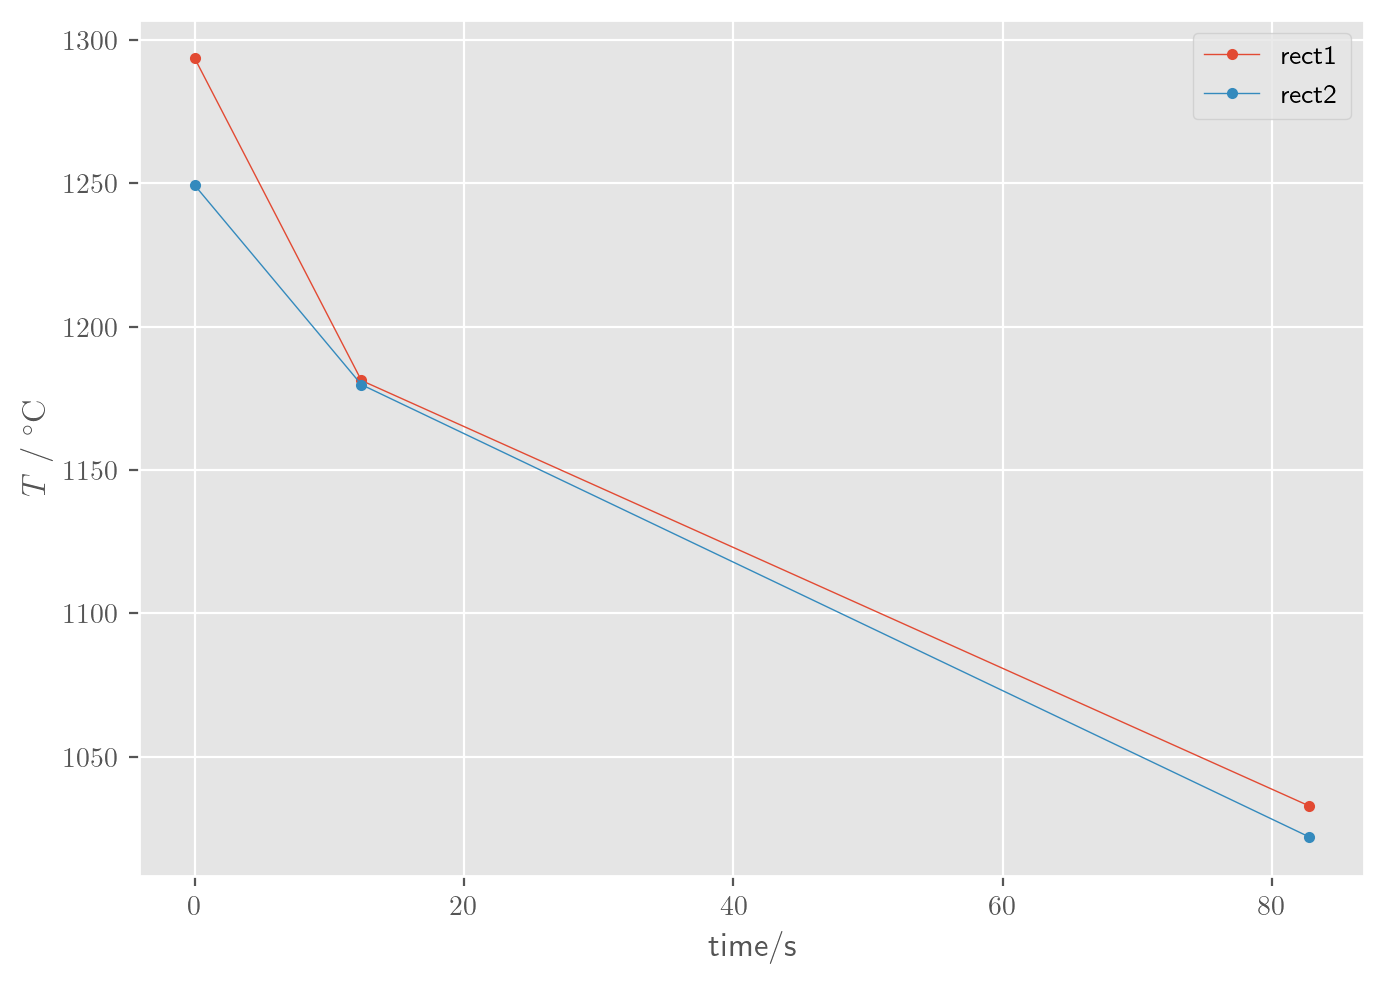

In [15]:
fig, ax = plt.subplots()

ax.plot(tl, max1, markevery=1, lw=.5, marker='.', label='rect1')
ax.plot(tl, max2, markevery=1, lw=.5, marker='.', label='rect2')

ax.set(xlabel='time/s', ylabel=r'$T\ /\ \mathrm{^\circ C}$')
ax.legend(loc='upper right')
fig.tight_layout(pad=1)